In [2]:
#import essential libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision import models
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import time
import copy
from tqdm import tqdm
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import pdb

In [3]:
#%automatic reloading during training
%load_ext autoreload
%autoreload 2

In [4]:
# set seed for  reproduciblity of the code
random_seed = 2023 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [5]:
# Set the device, check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


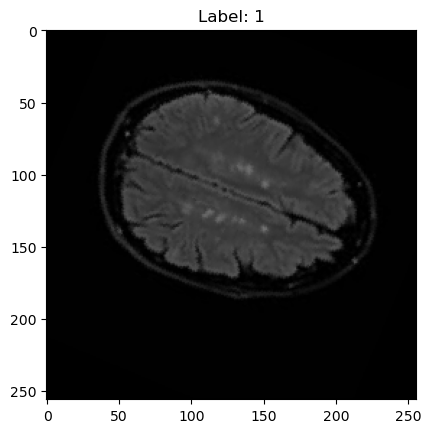

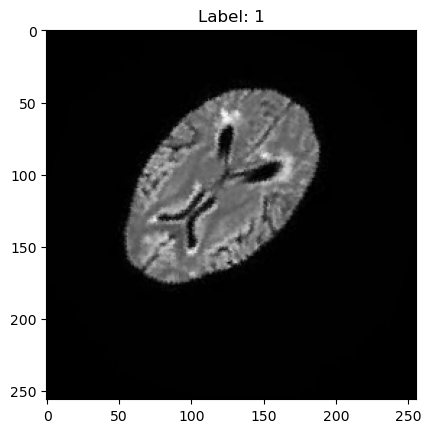

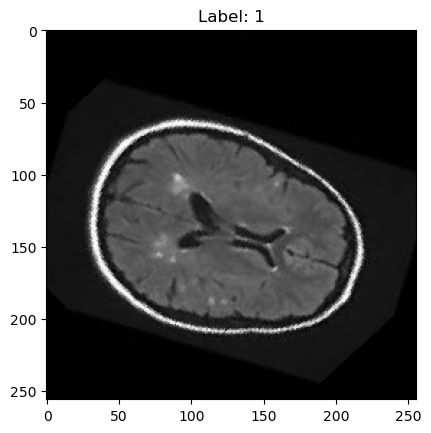

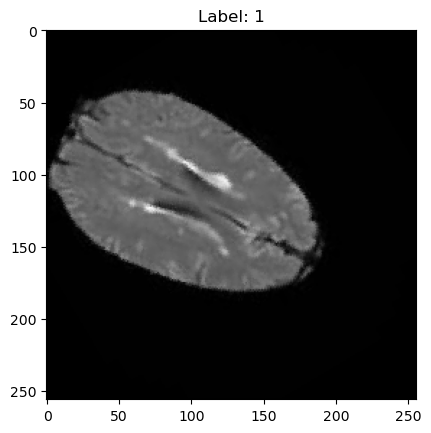

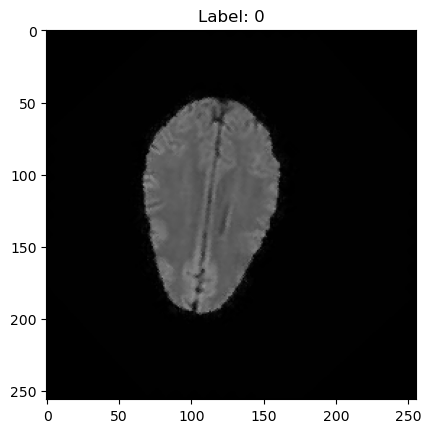

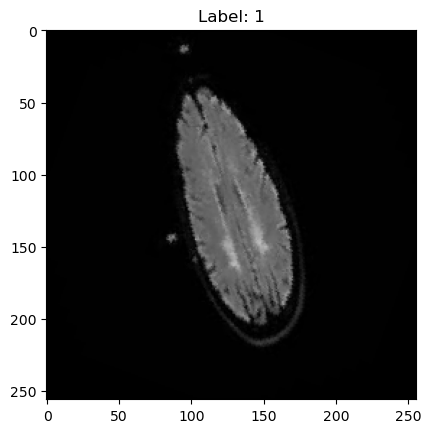

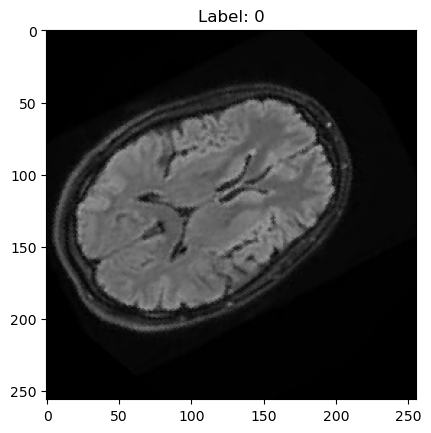

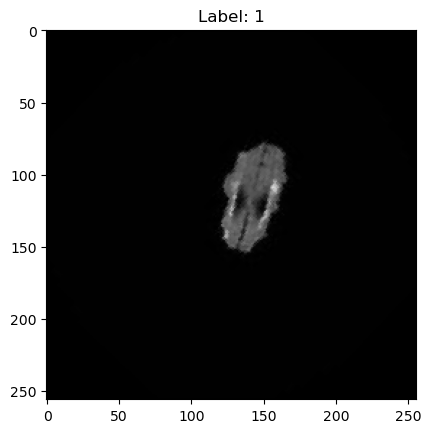

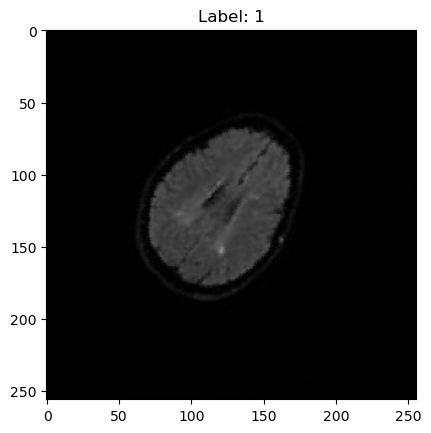

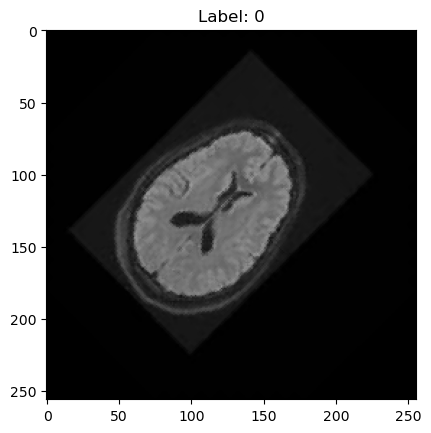

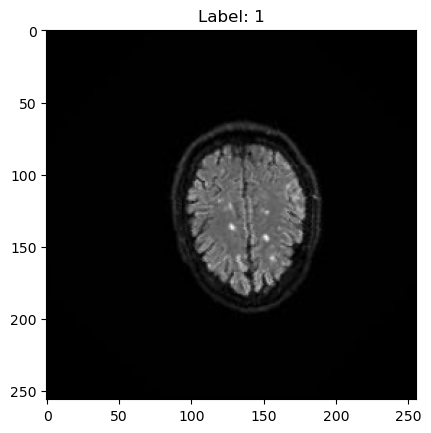

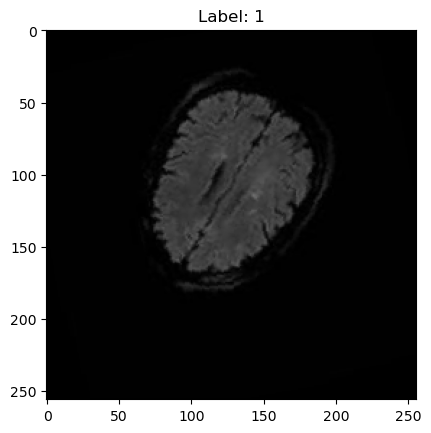

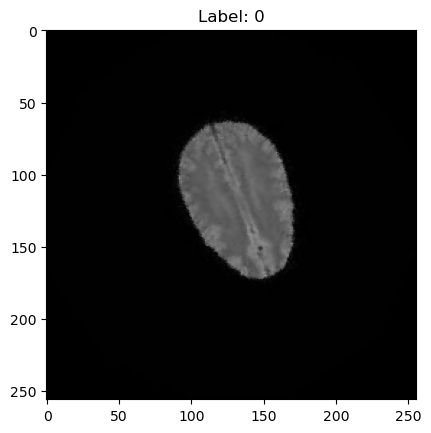

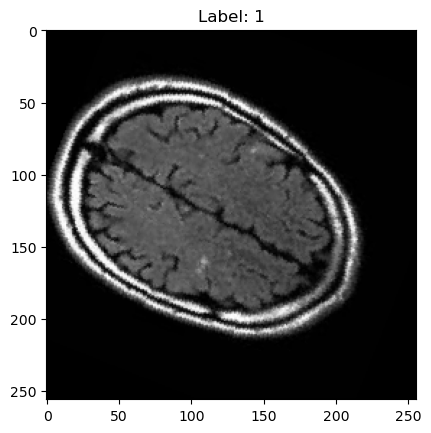

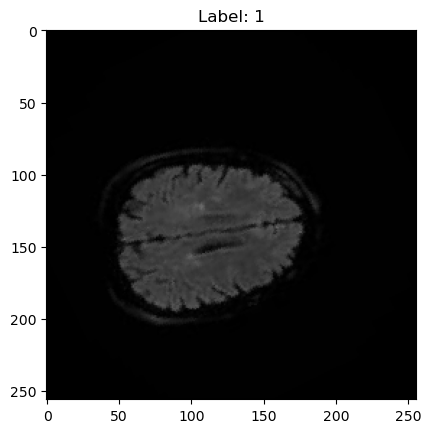

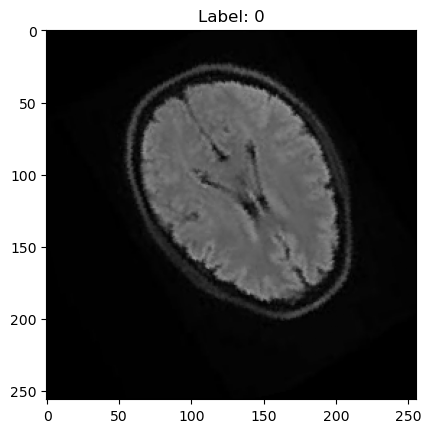

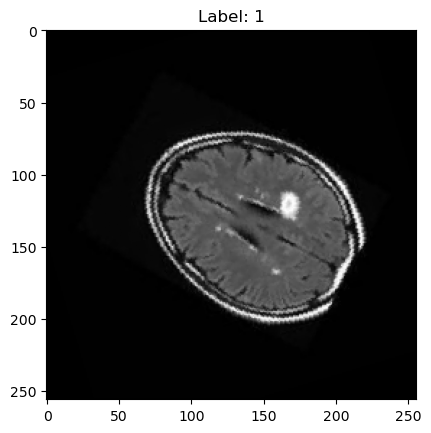

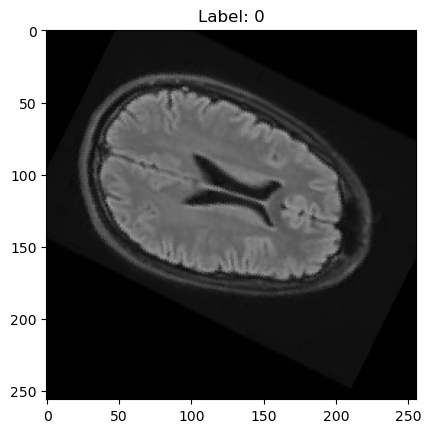

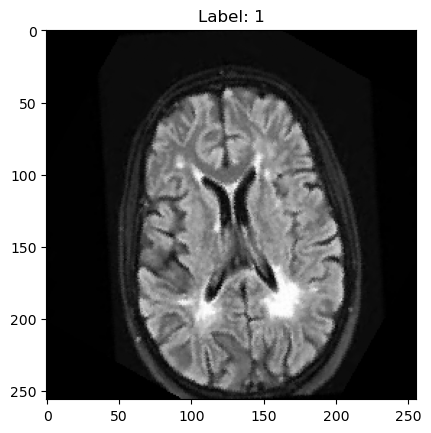

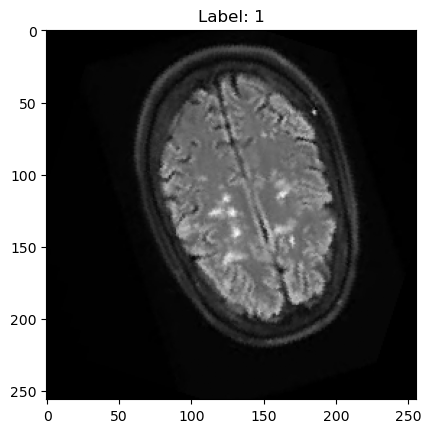

In [6]:
import os
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.RandomHorizontalFlip(),  # Add horizontal flipping
    transforms.RandomVerticalFlip(),  # Add vertical flipping
    
    transforms.RandomRotation(degrees=(-75, 75)),  # Add random rotation between -75 and 75 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])  # Normalize to [0, 1]
])  # Convert to PyTorch tensor


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Load images from both classes internally
        self.root_dir = root_dir  # Store root_dir for use in load_data
        self.data_positive = self.load_data(positive_class=True)
        self.data_negative = self.load_data(positive_class=False)
        self.data = self.data_positive + self.data_negative
        random.shuffle(self.data)  # Shuffle the combined dataset
        self.transform = transform  # Assign the transform

    def load_data(self, positive_class=True):
        data = []
        class_name = 'MS' if positive_class else 'noMS'
        class_label = 1 if positive_class else 0
        class_path = os.path.join(self.root_dir, class_name)  # Use self.root_dir

        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                img_path = os.path.join(class_path, filename)
                data.append((img_path, class_label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Create the Dataset (balanced with both classes)
dataset = CustomDataset(root_dir='C:\\Users\\hajami\\Desktop\\535-data', transform=transform)

# Visualize samples
import matplotlib.pyplot as plt

for i in range(20):
    image, label = dataset[i]
    plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions for visualization
    plt.title(f"Label: {label}")
    plt.show()


In [7]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the size as needed
    transforms.ToTensor(),
])
dataset = CustomDataset(root_dir='C:\\Users\\hajami\\Desktop\\535-data', transform=transform)

In [8]:
#split the dataset 
from torch.utils.data import random_split

# Split the dataset into train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.20 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Corrected calculation

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Access the individual datasets
print(len(train_data))  # Number of samples in the training set
print(len(val_data))    # Number of samples in the validation set
print(len(test_data))   # Number of samples in the test set

21420
6120
3060


In [9]:
#define the dataloader for training and testing loops
from torch.utils.data import DataLoader

train_len = len(train_data)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

val_len = len(val_data)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)

test_len = len(test_data)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

data_loaders = {'train':train_dataloader, 'val':val_dataloader}

In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


In [11]:
print(torch.cuda.is_available())

True


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from sklearn.metrics import f1_score

class PCAEClassifier(nn.Module):
    def __init__(self, hidden_units, num_classes, beta=20):
        super(PCAEClassifier, self).__init__()
        self.beta = beta  # Sparsity regularization parameter

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First hidden layer with 32 filters
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # Second hidden layer with 16 filters
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),  # Third hidden layer with 16 filters
            nn.ReLU(),
            nn.Conv2d(16, hidden_units, kernel_size=3, padding=1),  # Fourth hidden layer with 32 filters
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_units, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        # Classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_units * 256 * 256, 64),  # Adjust input size based on encoder output
            nn.ReLU(),
            nn.Dropout(0),  # Optional dropout for regularization
            nn.Linear(64, num_classes),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )

    def forward(self, x):
        batch_size = x.size(0)  # Add this line
        encoded = self.encoder(x)
        # print("encoded.shape:", encoded.shape)  # Print shape after encoding

        decoded = self.decoder(encoded)
        # print("decoded.shape:", decoded.shape)  # Print shape after decoding

        # Sparsity regularization term
        sparsity_loss = self.beta * torch.mean(torch.abs(encoded))

        # Classification output
       # logits = self.classifier(encoded.view(-1, 1048576))
        logits = self.classifier(encoded.view(batch_size, -1))

        return decoded, sparsity_loss, logits


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

# Assuming your PCAEClassifier class is defined earlier in your code

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the PCAE model with classification layer and move it to GPU
hidden_units = 32
num_classes = 2  # Assuming you still have two classes
beta_value = 20
pcae_model = PCAEClassifier(hidden_units, num_classes, beta=beta_value).to(device)

# Print the model summary
print(pcae_model)

# Define loss functions for reconstruction and classification
reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

# Split the dataset into train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.20 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Corrected calculation

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Access the individual datasets
print(len(train_data))  # Number of samples in the training set
print(len(val_data))    # Number of samples in the validation set
print(len(test_data))   # Number of samples in the test set

#define the dataloader for training and testing loops
from torch.utils.data import DataLoader

train_len = len(train_data)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

val_len = len(val_data)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)

test_len = len(test_data)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

data_loaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

# Move the optimizer creation after moving the model to GPU
optimizer = optim.Adam(pcae_model.parameters(), lr=0.000001, weight_decay=0.001)
# Training loop
num_epochs = 40
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []  # Store train accuracies
val_accuracies = []  # Store validation accuracies
test_accuracies = []  # Store test accuracies

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over train set
    pcae_model.train()  # Set model to training mode
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        decoded, sparsity_loss, logits = pcae_model(images)

        reconstruction_loss = reconstruction_criterion(decoded, images)
        classification_loss = classification_criterion(logits, labels)
        total_loss = reconstruction_loss + classification_loss + sparsity_loss

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

        # Calculate train accuracy
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store average train loss and accuracy per epoch
    epoch_train_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluation at the end of each epoch for validation and testing
    with torch.no_grad():
        # Validation
        running_val_loss = 0.0
        correct = 0
        total = 0
        pcae_model.eval()  # Set model to evaluation mode
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            _, _, logits = pcae_model(images)
            val_loss = reconstruction_criterion(_, images) + classification_criterion(logits, labels) + sparsity_loss
            running_val_loss += val_loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_losses.append(running_val_loss / len(val_dataloader))
        val_accuracies.append(val_accuracy)

        # Testing
        running_test_loss = 0.0
        correct = 0
        total = 0
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            _, _, logits = pcae_model(images)
            test_loss = reconstruction_criterion(_, images) + classification_criterion(logits, labels) + sparsity_loss
            running_test_loss += test_loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_losses.append(running_test_loss / len(test_dataloader))
        test_accuracies.append(test_accuracy)

        # Print results in the desired format
        print(f'Epoch {epoch + 1}/{num_epochs} - Avg. Train Loss: {epoch_train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_accuracy:.4f} - Test Loss: {test_losses[-1]:.4f} - Test Acc: {test_accuracy:.4f}')


PCAEClassifier(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=2097152, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear

C:\Users\hajami\AppData\Local\anaconda3\envs\Hanieh_second_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 3, 256, 256])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\hajami\AppData\Local\anaconda3\envs\Hanieh_second_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 256, 256])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\hajami\AppData\Local\anaconda3\envs\Hanieh_second_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20, 3, 256, 256])) that is different to the input size (

Epoch 1/40 - Avg. Train Loss: 1.3534 - Train Acc: 55.7003 - Val Loss: 1.2836 - Val Acc: 56.2582 - Test Loss: 1.2849 - Test Acc: 54.8039
Epoch 2/40 - Avg. Train Loss: 1.2771 - Train Acc: 59.9860 - Val Loss: 1.1721 - Val Acc: 58.6111 - Test Loss: 1.1722 - Test Acc: 58.8562
Epoch 3/40 - Avg. Train Loss: 1.2006 - Train Acc: 62.0682 - Val Loss: 1.0611 - Val Acc: 61.5033 - Test Loss: 1.0641 - Test Acc: 59.3464
Epoch 4/40 - Avg. Train Loss: 1.1225 - Train Acc: 62.6331 - Val Loss: 0.9642 - Val Acc: 62.5654 - Test Loss: 0.9660 - Test Acc: 62.3203
Epoch 5/40 - Avg. Train Loss: 1.0508 - Train Acc: 63.2400 - Val Loss: 0.8858 - Val Acc: 63.2190 - Test Loss: 0.8879 - Test Acc: 62.9412
Epoch 6/40 - Avg. Train Loss: 0.9939 - Train Acc: 63.5481 - Val Loss: 0.8361 - Val Acc: 63.5294 - Test Loss: 0.8387 - Test Acc: 63.3333
Epoch 7/40 - Avg. Train Loss: 0.9507 - Train Acc: 64.0243 - Val Loss: 0.7994 - Val Acc: 64.4935 - Test Loss: 0.8024 - Test Acc: 63.5294
Epoch 8/40 - Avg. Train Loss: 0.9176 - Train Acc

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate evaluation metrics
def calculate_metrics(model, dataloader):
    true_labels = []
    predicted_labels = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            _, _, logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, precision, recall, f1

# Calculate metrics for validation set
val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(pcae_model, val_dataloader)
print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_f1:.4f}")

# Calculate metrics for test set
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(pcae_model, test_dataloader)
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")


Validation Metrics:
Accuracy: 0.8886
Precision: 0.9069
Recall: 0.8682
F1-score: 0.8871

Test Metrics:
Accuracy: 0.8882
Precision: 0.9038
Recall: 0.8640
F1-score: 0.8834


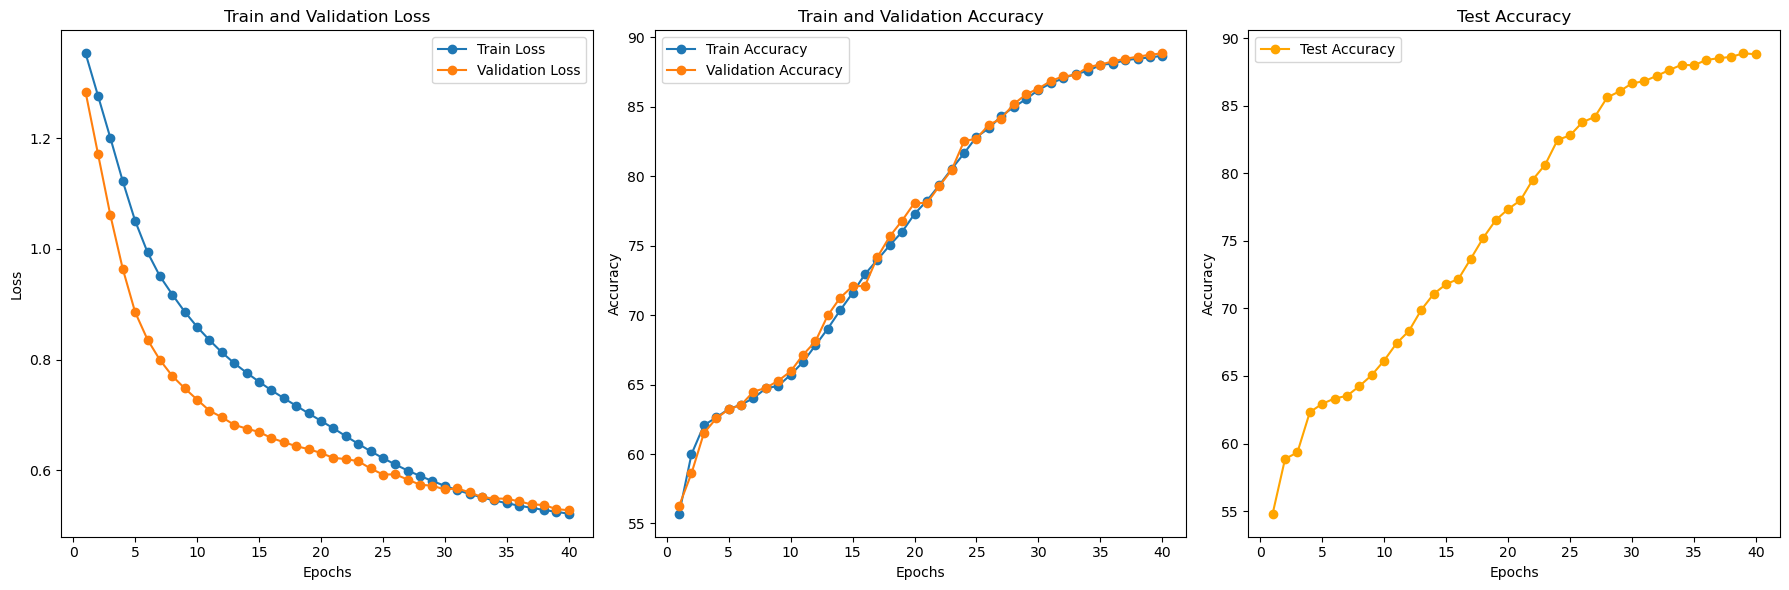

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(18, 6))  # Increase figure size for accommodating the third subplot

# Plot train loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot train accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


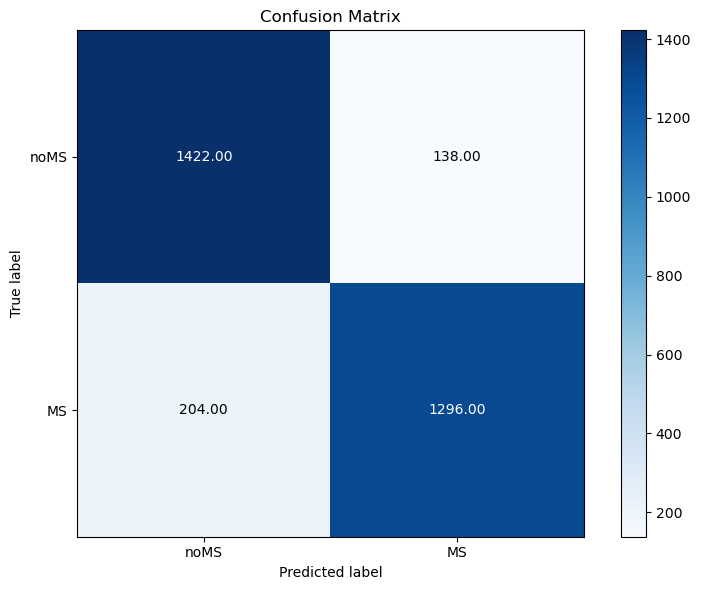

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            _, _, logits = model(images)
            _, predicted = torch.max(logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['noMS', 'MS'])
    plt.yticks(tick_marks, ['noMS', 'MS'])

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Call the function to plot confusion matrix for the test dataset
plot_confusion_matrix(pcae_model, test_dataloader)
